In [2]:
import numpy as np
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import math
import pathlib
import os
import time

# FaceMesh index
# https://github.com/google/mediapipe/blob/master/mediapipe/python/solutions/face_mesh_connections.py

In [3]:
def imgshow(frame):
  plt.figure(figsize = (20,20))
  plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

def euclaideanDistance(point, point1):
    x, y = point.x, point.y
    x1, y1 = point1.x, point1.y
    distance = math.sqrt((x1 - x)**2 + (y1 - y)**2)
    return distance

def ensureDir(path):
  pathlib.Path(path).mkdir(parents=True, exist_ok=True) 

def saveRecordData(path, data, file_name = None):
  if file_name == None:
    file_name = "%s" % time.time()
  final_path = os.path.join(path, file_name)
  np.save(final_path, data)

In [4]:
# Src Drawing utils
# https://github.com/google/mediapipe/blob/cf101e62a9d49a51be76836b2b8e5ba5c06b5da0/mediapipe/python/solutions/drawing_utils.py#L50

# Face Index map
# https://github.com/google/mediapipe/blob/a908d668c730da128dfa8d9f6bd25d519d006692/mediapipe/modules/face_geometry/data/canonical_face_model_uv_visualization.png

def process_landmark(frame, dispay=False):
  mp_face_mesh = mp.solutions.face_mesh
  with mp_face_mesh.FaceMesh(
      static_image_mode=False,
      max_num_faces=1,
      refine_landmarks=True,
      min_detection_confidence=0.5) as face_mesh:
    image = frame
    # Convert the BGR image to RGB before processing.
    results = face_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Print and draw face mesh landmarks on the image.
    if not results.multi_face_landmarks:
      return None, None

    if not dispay:
      return results.multi_face_landmarks[0], None

    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

    annotated_image = image.copy()
    for face_landmarks in results.multi_face_landmarks:
      # mp_drawing.draw_landmarks(
      #     image=annotated_image,
      #     landmark_list=face_landmarks,
      #     connections=mp_face_mesh.FACEMESH_TESSELATION,
      #     landmark_drawing_spec=drawing_spec,
      #     connection_drawing_spec=mp_drawing_styles
      #     .get_default_face_mesh_tesselation_style())
      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          # connections=mp_face_mesh.FACEMESH_IRISES,
          connections= [
            (159, 145), # left V
            (386, 374), # right V
            (33, 133), # left H
            (362, 263) # right H
          ],
          landmark_drawing_spec=drawing_spec
          )
    return results.multi_face_landmarks[0], annotated_image

def eyes_H_V_ratio(landmark):
  # Right eyes 
  # horizontal line 
  rh_right = landmark[362]
  rh_left = landmark[263]

  # vertical line 
  rv_top = landmark[386]
  rv_bottom = landmark[374]

  # LEFT_EYE 
  # horizontal line 
  lh_right = landmark[133]
  lh_left = landmark[33]
  # vertical line 
  lv_top = landmark[159]
  lv_bottom = landmark[145]

  rhDistance = euclaideanDistance(rh_right, rh_left)
  rvDistance = euclaideanDistance(rv_top, rv_bottom)
  lvDistance = euclaideanDistance(lv_top, lv_bottom)
  lhDistance = euclaideanDistance(lh_right, lh_left)

  reRatio = rhDistance/rvDistance
  leRatio = lhDistance/lvDistance
  ratio = (reRatio+leRatio)/2
  return (reRatio, leRatio, ratio)

def landmark_extract(landmark):
  # [(x,y,z),(x2,y2,z2)] -> [x,y,z,x2,y2,z2]
  flattern_data = np.array(list(map(lambda x: [x.x, x.y, x.z], landmark)))
  flattern_data = flattern_data.flatten()
  return flattern_data


def landmark_2d_extract(landmark):
  # [(x,y,z),(x2,y2,z2)] -> [x,y,x2,y2]
  flattern_data = np.array(list(map(lambda x: [x.x, x.y], landmark)))
  flattern_data = flattern_data.flatten()
  return flattern_data

## Blink Counter

In [46]:
vid = cv2.VideoCapture(0)
blink_count = 0
state = 'OPEN'
CLOSE_THRESHOLD = 3

while(True):
    # Capture the video frame
    # by frame
    ret, frame = vid.read()

    (res,annotated_image) = process_landmark(frame, True)

    # Display the resulting frame
    if annotated_image is not None:
        _,_, ratio = eyes_H_V_ratio(res.landmark)
        cv2.putText(annotated_image, 'Blink ratio: %s'% ratio, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

        if state == 'OPEN' and ratio > CLOSE_THRESHOLD: 
          state = 'CLOSE'
          blink_count+=1
        elif state == 'CLOSE' and ratio < CLOSE_THRESHOLD:
          state = 'OPEN'

        cv2.putText(annotated_image, 'State: %s'% state, (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        cv2.putText(annotated_image, 'Count: %s'% blink_count, (50,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

        cv2.imshow('frame', annotated_image)
      
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# After the loop release the cap object
vid.release()

# Destroy all the windows
cv2.destroyAllWindows()

# macos stuck
cv2.waitKey(1)

-1

## Face sequence records

In [157]:
vid = cv2.VideoCapture(0)
SEQUENCE_FRAME = 32
frame_count = 0

state = "PREPARE" # "BEGIN" "END"

# store 32 frames
acc_data = []
last_data = None

RECORD_ACTION = "two"
RECORD_DIR = "/Users/admin/Documents/projects/_research/Learning/python3_playground/mediapipe/data/" + RECORD_ACTION
ensureDir(RECORD_DIR)

while(True):
    # Capture the video frame
    # by frame
    ret, frame = vid.read()

    (res,annotated_image) = process_landmark(frame, True)

    # Display the resulting frame
    if annotated_image is not None:

        if state == "PREPARE":
            cv2.putText(annotated_image, 'Prepare: Say %s. A to start' % RECORD_ACTION.upper(), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        elif state == "BEGIN":
            cv2.putText(annotated_image, 'Record %s' % frame_count, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
            acc_data.append(landmark_2d_extract(res.landmark))    
            frame_count+=1
            if frame_count >= SEQUENCE_FRAME:
                state = "END"
        elif state == "END":
            saveRecordData(RECORD_DIR, np.array(acc_data))
            print('record done flush save file', len(acc_data))
            last_data = acc_data
            acc_data = []
            state = "PREPARE"
        
        cv2.imshow('frame', annotated_image)
        
      
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    inp = cv2.waitKey(10)
    if inp & 0xFF == ord('q'):
        break
    elif state == "PREPARE" and inp & 0xFF == ord('a'):
        state = "BEGIN"
        frame_count = 0

# After the loop release the cap object
vid.release()

# Destroy all the windows
cv2.destroyAllWindows()

# macos stuck
cv2.waitKey(1)

record done flush save file 32
record done flush save file 32
record done flush save file 32
record done flush save file 32
record done flush save file 32
record done flush save file 32
record done flush save file 32
record done flush save file 32


-1

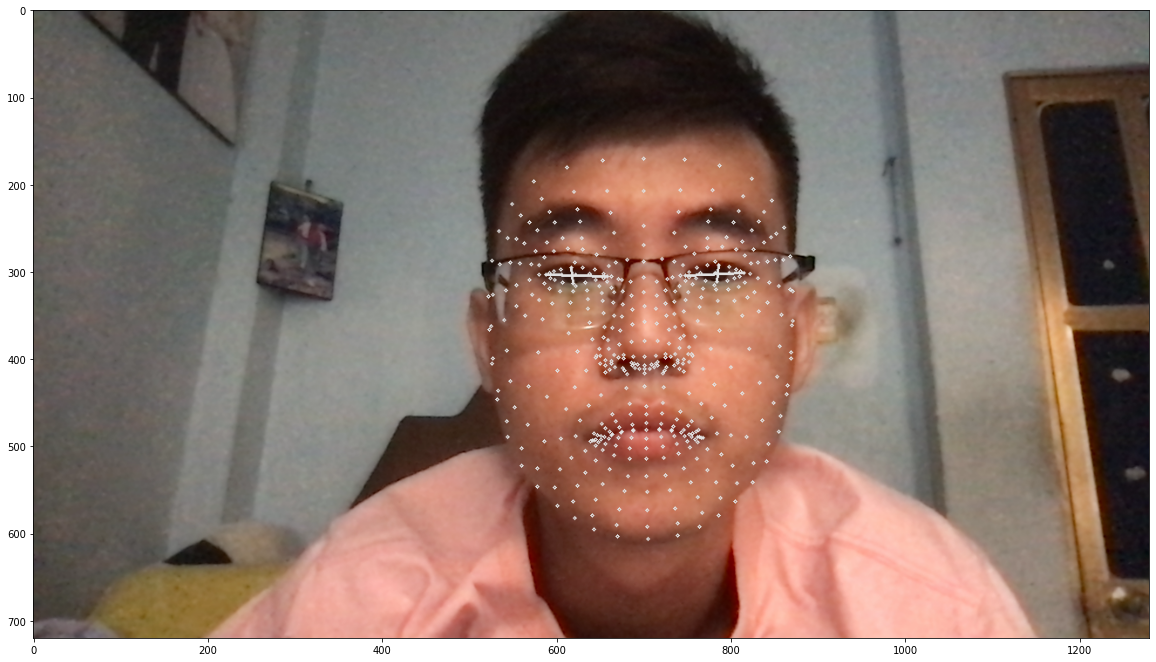

In [65]:
(res,annotated_image) = process_landmark(frame, True)
imgshow(annotated_image)

In [66]:
data = landmark_extract(res.landmark)
print(data.shape)

(1434,)


In [11]:
# process + flatten data
print(np.array(last_data).shape)
print(np.array(last_data).flatten())
print(np.array(last_data).flatten().shape)

(32, 956)
[0.52314788 0.65635389 0.52311951 ... 0.45042133 0.58400255 0.46699166]
(30592,)


In [6]:
# save
saveRecordData(RECORD_DIR, np.array(last_data).flatten())

In [60]:
# load
data = np.load("/Users/admin/Documents/projects/_research/Learning/python3_playground/mediapipe/data/one/1641192749.532864.npy")
data.shape
# print(data)

(32, 956)

## Data Load + Encode

In [10]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

DATA_DIR = "/Users/admin/Documents/projects/_research/Learning/python3_playground/mediapipe/data"
LABELS = ["one", "two"]
SEQUENCE_FRAME = 32

LABEL_MAP = {label: num for num, label in enumerate(LABELS)}
print(LABEL_MAP)

{'one': 0, 'two': 1}


In [11]:
def list_file_in_dir(path):
  return os.listdir(path)

In [12]:
X = []
Y = []

for action in LABELS:
  path = os.path.join(DATA_DIR, action)
  for file in list_file_in_dir(path):
    data = np.load(os.path.join(path, file))
    X.append(data)
    Y.append(LABEL_MAP[action])

X = np.array(X)
Y = np.array(Y)
Y = to_categorical(Y).astype(int)

In [13]:
print("X : %s\n Y: %s"% (X,Y))

X : [[[0.54908991 0.66447967 0.54998207 ... 0.46968642 0.60374683 0.48788866]
  [0.54999965 0.66416836 0.55040526 ... 0.46942645 0.60320532 0.48735434]
  [0.54936892 0.66532004 0.55071545 ... 0.4692401  0.60406899 0.48688388]
  ...
  [0.55189252 0.65889102 0.55326223 ... 0.46898511 0.60476857 0.48554891]
  [0.55039912 0.66187423 0.55379319 ... 0.46775833 0.6049704  0.48465782]
  [0.55073029 0.65983409 0.55359125 ... 0.46729898 0.60413969 0.48492706]]

 [[0.54672098 0.64157534 0.54623777 ... 0.45906276 0.60236096 0.47558835]
  [0.54710001 0.64102674 0.5465768  ... 0.45905638 0.60231215 0.47641569]
  [0.54664117 0.64215219 0.54622549 ... 0.45828992 0.60239232 0.47586286]
  ...
  [0.54733664 0.64016157 0.54686159 ... 0.4591549  0.60270894 0.47588977]
  [0.54809022 0.64056623 0.54669839 ... 0.45935139 0.60247076 0.47585538]
  [0.54663169 0.64244133 0.5478642  ... 0.45904145 0.60220653 0.47589067]]

 [[0.5299831  0.66146308 0.5287497  ... 0.47687334 0.58725995 0.49395198]
  [0.53273338 0.65

In [14]:
print(X.shape, Y.shape)

(60, 32, 956) (60, 2)


In [15]:
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.1)

In [16]:
print("Train: ", X_train.shape, Y_train.shape)
print("Test: ", X_test.shape, Y_test.shape)

Train:  (54, 32, 956) (54, 2)
Test:  (6, 32, 956) (6, 2)


## LSTM

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

# https://colab.research.google.com/drive/1ocuBlwRmuWsaXC1XUMHzBvvqnS9r4B3S#scrollTo=KBqMhk-HJTO5

In [166]:
LOG_DIR = "/Users/admin/Documents/projects/_research/Learning/python3_playground/mediapipe/log"
tb_callback = TensorBoard(log_dir=LOG_DIR)

In [167]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation="relu", input_shape=(32, 956)))
model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(np.array(LABELS).shape[0], activation="softmax"))

# return_sequences=True -> return data for next LSTM layer

In [168]:
model.compile(
  optimizer="Adam", 
  loss="CategoricalCrossentropy", 
  metrics=["CategoricalAccuracy"])

In [169]:
# view log. Open terminal. tensorboard --logdir=.
model.fit(X_train, Y_train, epochs=10000, callbacks= [tb_callback])

Epoch 1/10000


In [97]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 32, 64)            261376    
                                                                 
 lstm_7 (LSTM)               (None, 32, 128)           98816     
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 2)                 66        
                                                                 
Total params: 415,906
Trainable params: 415,906
Non-tr

In [110]:
model.save("actions.h5")

In [147]:
res = model.predict(X_test)
print(Y_test)

[[1 0]
 [1 0]]


In [148]:
i = 0
for itm,index in res:
  print ('predict', i, LABELS[np.argmax(itm)])
  i += 1

predict 0 one
predict 1 one


## Evalualte

In [7]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [8]:
# model.load_weights('actions.h5')
model = tf.keras.models.load_model('/Users/admin/Documents/projects/_research/Learning/python3_playground/mediapipe/model/categorical_accuracy')

2022-01-03 21:47:43.624495: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
Y_hat = model.predict(X_test)

In [19]:
Y_true = np.argmax(Y_test, axis=1).tolist()
Y_hat = np.argmax(Y_hat, axis=1).tolist()

In [20]:
multilabel_confusion_matrix(Y_true, Y_hat)

array([[[5, 0],
        [1, 0]],

       [[0, 1],
        [0, 5]]])

In [21]:
accuracy_score(Y_true, Y_hat)

0.8333333333333334

## Webcam - Test

In [22]:
vid = cv2.VideoCapture(0)
SEQUENCE_FRAME = 32
frame_count = 0

state = "PREPARE" # "BEGIN" "END"

# store 32 frames
acc_data = []
last_data = None
last_predict_action = ""
last_predict_score = 0

while(True):
    # Capture the video frame
    # by frame
    ret, frame = vid.read()

    (res,annotated_image) = process_landmark(frame, True)

    # Display the resulting frame
    if annotated_image is not None:

        if state == "PREPARE":
            cv2.putText(annotated_image, 'Prepare: A to start', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
            if last_predict_score != 0:
                cv2.putText(annotated_image, 'Last Predict: %s - %s' % (last_predict_action.upper(), last_predict_score), (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

        elif state == "BEGIN":
            last_predict_score = 0
            cv2.putText(annotated_image, 'Record %s' % frame_count, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
            acc_data.append(landmark_2d_extract(res.landmark))    
            frame_count+=1
            if frame_count >= SEQUENCE_FRAME:
                state = "END"
        elif state == "END":
            last_data = acc_data
            acc_data = []
            inp = np.expand_dims(np.array(last_data), axis=0)
            raw_predict = model.predict(inp)[0]
            idx = np.argmax(raw_predict)
            label = LABELS[idx]
            print(raw_predict[idx], label)
            last_predict_score = raw_predict[idx]
            last_predict_action = label
            state = "PREPARE"
        
        cv2.imshow('frame', annotated_image)
        
      
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    inp = cv2.waitKey(10)
    if inp & 0xFF == ord('q'):
        break
    elif state == "PREPARE" and inp & 0xFF == ord('a'):
        state = "BEGIN"
        frame_count = 0

# After the loop release the cap object
vid.release()

# Destroy all the windows
cv2.destroyAllWindows()

# macos stuck
cv2.waitKey(1)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


0.9896752 one
0.7720046 one
0.8037022 one
0.81424636 one
0.79005 one
0.7748337 one
0.80120575 one
0.7876201 one
0.83222413 one
0.78737944 one
0.7765197 one
0.79850084 one
0.7944313 one
0.8194221 one
0.81768566 one
0.8602467 one
0.8507954 one
0.88331074 one
0.8864776 one
0.8953295 one
0.9590102 one
0.9424178 one
0.92574984 one


-1

In [149]:
inp = np.expand_dims(np.array(last_data), axis=0)
raw_predict = model.predict(inp)[0]
idx = np.argmax(raw_predict)
label = LABELS[idx]
print(raw_predict[idx], label)
print(raw_predict)

0.9999975 two
[2.467379e-06 9.999975e-01]
